In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
import subprocess
import shutil
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, to_hex
from src.metat import metat_load, metat_load_summary

%load_ext autoreload
%autoreload 2

In [2]:
cmap_blues = LinearSegmentedColormap.from_list('blues', ['lightblue', 'steelblue'])
cmap_grays = LinearSegmentedColormap.from_list('grays', ['lightgray', 'gray'])

def cmap_sample(cmap, n):
    return [to_hex(color) for color in cmap(np.linspace(0, 1, n))]

In [3]:

# Want to evaluate the likelihood of other potential hosts. Look for all other Methanoperedens in the bioreactors. 
# For some reason, it seems like things aren't appropriately-labeled in the coassembly. 
organism_info_df = list()
for path in glob.glob('../data/ggkbase/*organism_info.tsv'):
    organism_info_df.append(load_organism_info(path))
organism_info_df = pd.concat(organism_info_df)

mp_organism_info_df = organism_info_df[organism_info_df.taxonomy.str.contains('Methanoperedens') | organism_info_df.index.str.contains('Methanoperedens')].copy()
bb_organism_info_df = organism_info_df[organism_info_df.index.str.contains('Black_Borg')].copy()


In [4]:
def run_fastani(input_dir:str='../data/ggkbase/contigs', output_dir:str='../data/ggkbase'):
    input_list_path = os.path.join('.', 'fastani_input.txt')
    output_path = os.path.join(output_dir, 'fastani.tsv')
    input_paths = list(glob.glob(os.path.join(input_dir, '*')))
    with open(input_list_path, 'w') as f:
        f.write('\n'.join(input_paths))
    cmd = f'fastANI --ql {input_list_path} --rl {input_list_path} -o {output_path}'
    subprocess.run(cmd, shell=True, check=True)
    os.remove(input_list_path)
    
# run_fastani()

def load_fastani(path:str='../data/ggkbase/fastani.tsv'):
    cols = ['query_genome_path', 'ref_genome_path', 'ani', 'n_aligned', 'n_fragments']
    fastani_df = pd.read_csv(path, sep='\t', names=cols)
    fastani_df['query_genome_id'] = fastani_df.query_genome_path.apply(lambda path : os.path.basename(path).replace('.contigs.fa', ''))
    fastani_df['ref_genome_id'] = fastani_df.ref_genome_path.apply(lambda path : os.path.basename(path).replace('.contigs.fa', ''))
    return fastani_df

In [5]:
threshold = 99
mp_genome_ids = mp_organism_info_df.index.tolist()

fastani_df = load_fastani()
fastani_df = fastani_df[fastani_df.ani > threshold].copy()
fastani_df = fastani_df[fastani_df.query_genome_id.isin(mp_genome_ids) | fastani_df.ref_genome_id.isin(mp_genome_ids)].copy()

edges = list(zip(fastani_df.query_genome_id, fastani_df.ref_genome_id))
graph = nx.Graph(edges)
strains = list(nx.connected_components(graph))
print('Num. separate Methanoperedens strains:', len(strains))

strain_ids = {genome_id:f'mp_{i + 1}' for i, genome_ids in enumerate(strains) for genome_id in genome_ids}

mp_organism_info_df['strain_id'] = mp_organism_info_df.index.map(strain_ids)
# Use the biggest assembly as the representative. These are the ones used to create the id_to_ggkbase_name_map.
mp_organism_info_df = mp_organism_info_df.sort_values('bin_length', ascending=False).drop_duplicates('strain_id')
mp_organism_info_df = mp_organism_info_df.reset_index()

Num. separate Methanoperedens strains: 5


In [6]:
# for id_, ggkbase_name in id_to_ggkbase_name_map.items():
#     subprocess.run(f'cp ../data/ggkbase/contigs/{ggkbase_name}.contigs.fa ../data/data/{id_}.fn', shell=True, check=True)
#     subprocess.run(f'cp ../data/ggkbase/genbank/{ggkbase_name}.gbk ../data/data/{id_}.gbk', check=True, shell=True)

for id_, ggkbase_name in id_to_ggkbase_name_map.items():
    gff_file = GenBankFile.from_file(f'../data/ggkbase/genbank/{ggkbase_name}.gbk')
    gff_file.to_gff(f'../data/data/{id_}.gff')
    gff_file.to_fasta(f'../data/data/{id_}.fa')

In [28]:
coverm_df = coverm_load('../data/coverm', contig_sizes=contig_sizes)
coverm_df['bioreactor'] = coverm_df.sample_id.str.match(r'ck_.*|n_.*')
coverm_df = coverm_df[coverm_df.bioreactor].copy()

def remove_low_abundance_targets(coverm_df, min_rpkm:float=1, min_n_samples:int=1):
    include_target_names = coverm_df.groupby('target_name').apply(lambda df : (df.rpkm > min_rpkm).sum() > min_n_samples, include_groups=False)
    include_target_names = include_target_names[include_target_names].index 
    n_target_names = coverm_df.target_name.nunique()
    print(f'remove_low_abundance_targets: Retaining {len(include_target_names)} out of {n_target_names} targets after filtering for abundance.')
    return coverm_df[coverm_df.target_name.isin(include_target_names)].copy()

In [29]:
def plot_abundance(figure_df:pd.DataFrame, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2, legend:bool=True, ax=None):

    figure_df = figure_df.sort_values(['sample_id', 'rpkm'])
    figure_df['year'] = [re.search(r'202\d', sample_id).group(0) for sample_id in figure_df.sample_id]
    figure_df = remove_low_abundance_targets(figure_df, min_rpkm=min_rpkm)
    
    sample_ids = figure_df.sample_id.unique()
    n_samples = figure_df.sample_id.nunique()

    target_names = figure_df.target_name.unique()[::-1]
    palettes = dict()
    palettes['2024'] = dict(zip(target_names, cmap_sample(cmap_grays, len(target_names))))
    palettes['2025'] = dict(zip(target_names, cmap_sample(cmap_blues, len(target_names))))
    # print(palettes)

    bottom = np.zeros(n_samples)
    for target_name, df in figure_df.groupby('target_name'):
        colors = [palettes[year].get(target_name, 'red') for year in df.year]
        heights = df.set_index('sample_id').rpkm.to_dict() # Make this robust to when some samples aren't present. 
        heights = np.array([heights.get(sample_id, 0) for sample_id in sample_ids])
        ax.bar(x=np.arange(n_samples), height=heights, bottom=bottom, label=target_name, edgecolor='black', lw=0.7, color=colors)
        bottom += heights
    ax.set_title(title)
    ax.set_ylabel('RPKM')
    ax.set_xticks(np.arange(n_samples), labels=[sample_id.replace('_metat', '') for sample_id in sample_ids], rotation=90)

    if legend:
        ax.legend()


remove_low_abundance_targets: Retaining 5 out of 5 targets after filtering for abundance.
remove_low_abundance_targets: Retaining 4 out of 25 targets after filtering for abundance.


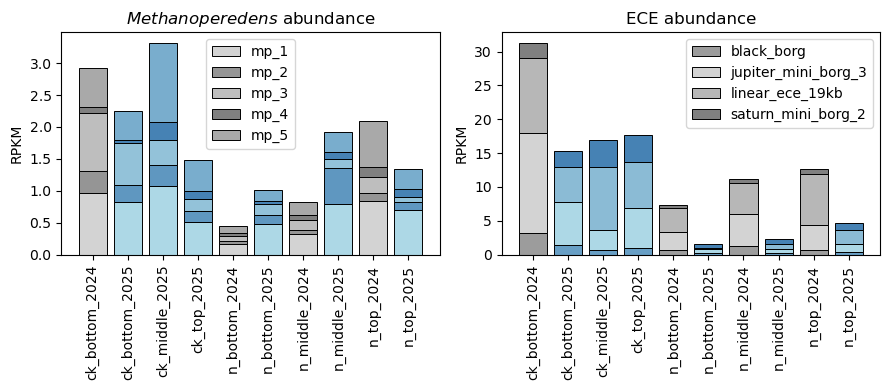

In [30]:

fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)

plot_abundance(coverm_df[coverm_df.target_name.str.startswith('mp_')], ax=ax_a, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2)
plot_abundance(coverm_df[~coverm_df.target_name.str.startswith('mp_')], ax=ax_b, title='ECE abundance', min_rpkm=1)

fig.tight_layout()
plt.show()

In [23]:
interproscan_df = load_interproscan().rename(columns={'id':'gene_id'}).drop(columns=['length'])
interproscan_df = interproscan_df[interproscan_df.target_name.str.startswith('mp_')]

def is_ribosome_protein(df):
    # ribosome_proteins = ['L2,', 'L3,', 'L4,', 'L5,', 'L6,', 'L14,', 'L16,', 'L18,', 'L22,', 'L24,', 'S3,', 'S8,', 'S10,', 'S17', 'S19', 'L31']
    mask = (df.signature_description.str.contains('ribosomal', case=False) & df.signature_description.str.contains('L|S|P', regex=True))
    # https://pmc.ncbi.nlm.nih.gov/articles/PMC9399092/
    exclude_signatures = ['methyltransferase', 'METHYLTRANSFERASE', 'METHYLTHIOTRANSFERASE', 'PROCESSING', 'acetyltransferase', 'MODIFICATION', '40S']
    exclude_signatures += ['Ribosomal protein S5 domain 2-like', 'Brix'] # https://www.ebi.ac.uk/interpro/entry/InterPro/IPR020568/
    mask = mask & (~df.signature_description.str.contains('|'.join(exclude_signatures), regex=True))
    return mask

get_ribosome_protein = lambda description : re.search(r'(S|L|P)\d+', description).group(0) if (re.search(r'(S|L|P)\d+', description)) is not None else 'none'
ribosome_proteins_df = interproscan_df[is_ribosome_protein(interproscan_df)].copy()
ribosome_proteins_df['protein'] = [get_ribosome_protein(description) for description in ribosome_proteins_df.signature_description]
ribosome_proteins_df = ribosome_proteins_df.sort_values('e_value').drop_duplicates(['target_name', 'protein'])

for target_name, df in ribosome_proteins_df.groupby('target_name'):
    print(f'Num. ribosomal proteins found in {target_name}:', len(df))

ribosome_proteins_df.to_csv('mp_ribosome_proteins.csv')

Num. ribosomal proteins found in mp_1: 59
Num. ribosomal proteins found in mp_2: 1
Num. ribosomal proteins found in mp_3: 48
Num. ribosomal proteins found in mp_4: 57
Num. ribosomal proteins found in mp_5: 57


In [26]:
metat_summary_df = metat_load_summary()
metat_summary_df['genome_size'] = metat_summary_df.target_name.map(genome_sizes)
# metat_summary_df = metat_summary_df[metat_summary_df.sample_id.str.contains('n_|ck_')].copy() 
metat_summary_df['rpkm'] = metat_summary_df['total'] / (metat_summary_df.genome_size / 1e3) / (metat_summary_df.library_size / 1e6)

metat_df = metat_load()
ribosome_proteins_metat_df = metat_df.merge(ribosome_proteins_df, on=['target_name', 'gene_id'], how='inner')
ribosome_proteins_metat_df['rpkm'] = ribosome_proteins_metat_df.read_count / (ribosome_proteins_metat_df.length / 1e3) / (ribosome_proteins_metat_df.library_size / 1e6)
ribosome_proteins_metat_df = ribosome_proteins_metat_df.groupby(['sample_id', 'target_name']).rpkm.mean().reset_index(name='rpkm')

remove_low_abundance_targets: Retaining 5 out of 5 targets after filtering for abundance.
remove_low_abundance_targets: Retaining 3 out of 23 targets after filtering for abundance.


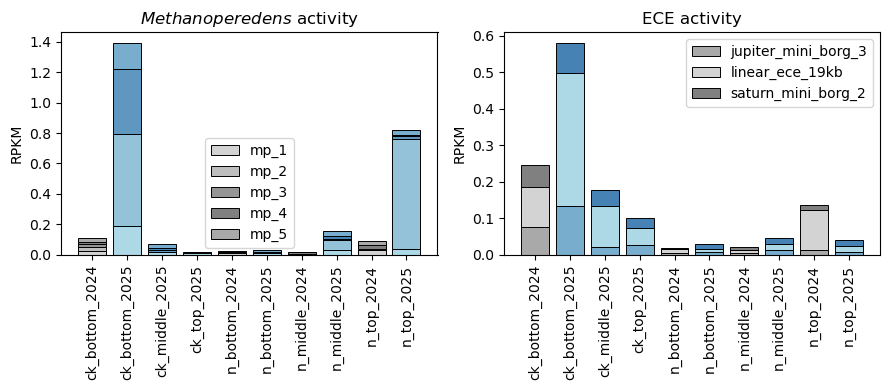

In [31]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)

# plot_abundance(metat_summary_df[metat_summary_df.target_name.str.startswith('mp_')], ax=ax_a, title=r'$\it{Methanoperedens}$ activity', min_rpkm=1e-2)
plot_abundance(ribosome_proteins_metat_df, ax=ax_a, title=r'$\it{Methanoperedens}$ activity', min_rpkm=1e-2)
plot_abundance(metat_summary_df[~metat_summary_df.target_name.str.startswith('mp_')], ax=ax_b, title='ECE activity', min_rpkm=5e-2)

fig.tight_layout()
plt.show()